In [117]:
import pandas as pd
import numpy as np
#import unidecode
from plotnine import *
import matplotlib.pyplot as plt
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot

# Factors impacting performance in NHL 

## Team 6 - Ali Iftikhar and Trevor Haynes

Presentation Video link: https://www.youtube.com/watch?v=NXqRy_hN3SU 

### Introduction

In our project, we analyzed different factors which can measure performance in NHL (National Hockey League). Our purpose was to identify certain factors which affect performance on two levels: 
1) The Team Level (macro level): We picked a few factors from our data to see how they impact a team's wins and losses

2) The Player Level (micro level): We tried to see where the best players in the world come from.

After identifying these factors, we discussed their impacts on team performance in an attempt to help teams and players help their scores. Our findings showed us that for team performance, factors such as Age, Experience, Height, Weight, Right-handed/Left-handed don't show significant signs of having an impact on a team's performance whereas the amount of money invested by a team in its players (Salary) did show some positive correlation with a higher win loss ratio. Another variable which had a slightly smaller impact was that of the team's rink starting side. One factor that our data fails to capture is that of 'Spirit' or management. We came across at least 2 cases (outliers) which exhibited certain characteristics which defied our findings.  

### Data

We collected our data from the NHL websites. The datasets were obtained through web scraping and were merged with each other using variables such as 'game_id', 'player_id' and 'team_id'. We only looked at the NHL season of 2017-2018 and narrowed our analysis to that season to allow us to focus on factors within one season, specifically on factors related players and teams that do not differ too much during a season and those that would answer the questions we have. 

To add accuracy to our results, we removed data of players who were from countries which had less than 30 players and those players who had played less than 15 games (there were around 1300 games played in the 2017-2018 season). After removing those entries, we still ended up with a data of around 650 players and 31 teams which was more than enough for us to derive some interesting insights from the data.

In [118]:
s1718 = pd.read_excel("NHL 2017-18.xls", header = 2)

cntrs = s1718.groupby(by=['Cntry'])
to_keep = [i for i in cntrs.size().index if cntrs.size()[i] > 30]
players_15_or_more_games = s1718[s1718['Cntry'].isin(to_keep)]

players_15_or_more_games = players_15_or_more_games[players_15_or_more_games['GP'] > 15]
players_15_or_more_games.rename(columns = {'NHLid' : 'player_id'}, inplace = True)

In [119]:
gamer_stats = pd.read_csv('game_skater_stats.csv')
gamer_stats = gamer_stats[['game_id', 'player_id','team_id']]
teams_data = pd.merge(gamer_stats, players_15_or_more_games, how = 'left')
teams_data = teams_data[teams_data['Born'].notnull()]
teams_data = teams_data[teams_data['game_id'] > 2017100000]
teams_data = teams_data[['Team', 'game_id', 'player_id', 'team_id']]
teams_data['teams_correct'] = teams_data['Team'].apply(lambda x: 1 if (len(x) == 3) else 0) 
teams_data = teams_data[teams_data['teams_correct'] == 1]
teams_data = teams_data[['Team', 'game_id', 'player_id', 'team_id']]
team_id_name = teams_data.groupby(['Team', 'team_id']).count().index

teams_check_list_index = list(teams_data.groupby(['Team', 'team_id']).count().index)
teams_check_list_amount = list(teams_data.groupby(['Team', 'team_id']).count()['game_id'])
teams_check_list = list(zip(teams_check_list_index, teams_check_list_amount))
teams_check_2 = sorted(teams_check_list, key = lambda x: x[1])[-31:]
team_id_final = [(i[0], i[1]) for i,j in teams_check_2]
team_id_final_df = pd.DataFrame(team_id_final, columns = ['Team','team_id'])

teams_data_2 = pd.merge(team_id_final_df, teams_data, how = 'left')
#teams_data_2.groupby(['team_id', 'game_id']).count().index
teams_data_2_final = teams_data_2.groupby(['Team', 'team_id', 'game_id']).count()
teams_data_2_final = teams_data_2_final.reset_index()
teams_data_2_final.drop(columns = ['player_id'], inplace = True)

In [120]:
game_wins_file = pd.read_csv("game.csv")
game_wins_file.columns
game_wins_file = game_wins_file[game_wins_file['season'] == 20172018]
game_wins_file['outcome_home_away'] = game_wins_file['outcome'].apply(lambda x: x[:x.find(' ')])
game_wins_file_home = game_wins_file[game_wins_file['outcome_home_away'] == 'home']
game_wins_file_away = game_wins_file[game_wins_file['outcome_home_away'] == 'away']
game_wins_file_home['Winning_team_id'] = game_wins_file_home['home_team_id']
game_wins_file_home['Winning_team_goals'] = game_wins_file_home['home_goals']
game_wins_file_home['Losing_team_goals'] = game_wins_file_home['away_goals']
game_wins_file_home['Losing_team_id'] = game_wins_file_home['away_team_id']
game_wins_file_home['starting_side_right'] = game_wins_file_home['home_rink_side_start'].apply(lambda x: 1 if (x=='right') else 0)
game_wins_file_home['starting_side_left'] = game_wins_file_home['home_rink_side_start'].apply(lambda x: 1 if (x=='left') else 0)
game_wins_file_away['Winning_team_id'] = game_wins_file_away['away_team_id']
game_wins_file_away['Losing_team_id'] = game_wins_file_away['home_team_id']
game_wins_file_away['Winning_team_goals'] = game_wins_file_away['away_goals']
game_wins_file_away['Losing_team_goals'] = game_wins_file_away['home_goals']
game_wins_file_away['starting_side_right'] = game_wins_file_away['home_rink_side_start'].apply(lambda x: 1 if (x == 'left') else 0)
game_wins_file_away['starting_side_left'] = game_wins_file_away['home_rink_side_start'].apply(lambda x: 1 if (x == 'right') else 0)
game_wins_file_updated = pd.concat([game_wins_file_home, game_wins_file_away], axis = 0)
game_wins_file_updated['goal diff'] = ((game_wins_file_updated['home_goals'] - game_wins_file_updated['away_goals'])**2)**(0.5)
#game_wins_file_updated['Winning_team_start_side'].fillna('NA', inplace = True)
game_wins_file_updated['home_team_win'] = game_wins_file_updated['outcome_home_away'].apply(lambda x : 1 if (x == 'home') else 0)
game_wins_file_updated['away_team_win'] = game_wins_file_updated['outcome_home_away'].apply(lambda x : 1 if (x == 'away') else 0)
game_wins_file_updated['away_team_win'] = game_wins_file_updated['outcome_home_away'].apply(lambda x : 1 if (x == 'away') else 0)
#game_wins_file_updated['Winning_team_start_side'].iloc[:50]
game_wins_file_updated_home = game_wins_file_updated[['game_id', 'season', 
                                                 'away_team_id', 'home_team_id', 'away_goals', 
                                                 'home_goals', 'home_team_win', 'away_team_win','Winning_team_id', 
                                                 'Winning_team_goals', 'Losing_team_goals', 
                                                 'Losing_team_id', 'starting_side_left','starting_side_right', 'goal diff']]

game_wins_file_updated_away = game_wins_file_updated[['game_id', 'season', 
                                                 'away_team_id', 'home_team_id', 'away_goals', 
                                                 'home_goals', 'home_team_win', 'away_team_win', 'Winning_team_id', 
                                                 'Winning_team_goals', 'Losing_team_goals', 
                                                 'Losing_team_id', 'starting_side_left','starting_side_right', 'goal diff']]

game_wins_file_updated_home['team_id'] = game_wins_file_updated_home['home_team_id'].copy()
game_wins_file_updated_away['team_id'] = game_wins_file_updated_away['away_team_id'].copy()
#game_wins_file_updated_home['outcome_home_away']

game_wins_file_updated_fr = pd.concat([game_wins_file_updated_home, game_wins_file_updated_away], axis = 0)


<ipython-input-120-b71e32225505>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-120-b71e32225505>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-120-b71e32225505>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-120-b71

In [121]:
teams_merged = pd.merge(teams_data_2_final, game_wins_file_updated_fr, how = 'inner', on = 'team_id')
testing = teams_merged.groupby(['game_id_y']).mean()
testing.columns
testing[['away_team_id', 'home_team_id', 'away_goals', 'home_goals', 'home_team_win', 'away_team_win', 
         'Winning_team_id', 'Winning_team_goals', 'Losing_team_goals', 'Losing_team_id', 'starting_side_left',
         'starting_side_right', 'goal diff']]
testing[['home_team_win', 'away_team_win']]
testing[['away_team_id', 'home_team_id']]

testing2 = testing.groupby(['away_team_id']).mean()
testing_home = testing[['home_team_id', 'home_goals', 'away_goals', 'home_team_win', 'away_team_win', 'starting_side_left', 
                        'starting_side_right', 'goal diff']].copy()
testing_away = testing[['away_team_id', 'home_goals', 'away_goals', 'home_team_win', 'away_team_win', 'starting_side_left', 
                        'starting_side_right', 'goal diff']].copy()
testing_home = testing_home.astype(int)
testing_away = testing_away.astype(int)
testing_home.rename(columns = {'home_team_id': 'team_id', 'home_goals': 'goals_scored', 'away_goals': 'goals_conceded', 
                               'home_team_win':'outcome_win?', 'away_team_win': 'outcome_lost?', 'starting_side_left':'start_side_left',
                               'starting_side_right':'start_side_right'}, inplace = True)
testing_away.rename(columns = {'away_team_id': 'team_id', 'away_goals': 'goals_scored', 'home_goals': 'goals_conceded', 
                               'away_team_win':'outcome_win?', 'home_team_win': 'outcome_lost?', 'starting_side_right':'start_side_left',
                               'starting_side_left':'start_side_right'}, inplace = True)
testing3 = pd.concat([testing_home, testing_away], axis = 0)
testing3.reset_index(inplace = True)
testing3.drop(columns = ['game_id_y'], inplace = True)
teams_sum_stats = testing3.groupby(['team_id']).sum()
teams_sum_stats.drop(columns = ['goal diff'], inplace = True)
teams_sum_stats['win-loss'] = teams_sum_stats['outcome_win?'] - teams_sum_stats['outcome_lost?']
teams_sum_stats['win-loss-ratio'] = teams_sum_stats['outcome_win?']/teams_sum_stats['outcome_lost?']
teams_sum_stats.rename(columns = {'goal diff' : 'goal_diff'}, inplace = True)

In [122]:
teams_mean_stats = testing3.groupby(['team_id']).mean()
teams_mean_stats.rename(columns = {'goals_scored' : 'goals_scored_average', 'goals_conceded' : 'goals_conceded_average', 
                                   'outcome_win?' : 'outcome_win?_average', 'outcome_lost?': 'outcome_lost?_average', 
                                   'start_side_left' : 'start_side_left_average', 'start_side_right':'start_side_right_average', 
                                   'goal diff' : 'goal_diff_average'}, inplace = True)
#teams_mean_stats.columns

team_stats_temp = teams_sum_stats.join(teams_mean_stats)
team_stats = team_stats_temp[['goals_scored', 'goals_scored_average', 'goals_conceded', 'goals_conceded_average', 
                              'outcome_win?', 'outcome_win?_average', 'outcome_lost?', 'outcome_lost?_average',
                              'start_side_left', 'start_side_left_average', 'start_side_right', 'start_side_right_average',
                               'win-loss', 'win-loss-ratio', 'goal_diff_average']]                            

team_id_final_df.set_index('team_id', inplace = True)
team_stats_final = team_stats.join(team_id_final_df)
team_stats_final.set_index('Team', inplace = True)

teams = list(players_15_or_more_games['Team'].value_counts()[players_15_or_more_games['Team'].value_counts()>11].index)
single_team_players = players_15_or_more_games[players_15_or_more_games['Team'].isin(teams)]
#number of players, games played by a team, goals scored by a team, games played average, number of players average
teams_games = pd.DataFrame(single_team_players[['Team','GP']].groupby(by = ['Team']).max()).rename({'GP': 'Games_per_team'}, 
                                                                                                   axis = 1).reset_index()

team_stats_final_1 = team_stats_final.join(teams_games.set_index('Team'))

In [123]:
single_team_players['Stick'].fillna('NAA', inplace = True)
single_team_players['Stick_Brand'] = single_team_players['Stick'].apply(lambda x: x[:x.find(' ')])
single_team_players['Glove'].fillna('NAA', inplace = True)
single_team_players['Glove_Brand'] = single_team_players['Glove'].apply(lambda x: x[:x.find(' ')])
single_team_players['Pants'].fillna('NAA', inplace = True)
single_team_players['Pants_Brand'] = single_team_players['Pants'].apply(lambda x: x[:x.find(' ')])
single_team_players['Helmet'].fillna('NAA', inplace = True)
single_team_players['Helmet_Brand'] = single_team_players['Helmet'].apply(lambda x: x[:x.find(' ')])
single_team_players['Skates'].fillna('NAA', inplace = True)
single_team_players['Skates_Brand'] = single_team_players['Skates'].apply(lambda x: x[:x.find(' ')])


team_stats_means = single_team_players.groupby(['Team']).mean()[['Ht', 'Wt', 'Age', 'Seasons', 'Salary', 'CriG']]
team_stats_dummies_nat = pd.get_dummies(single_team_players['Nat'], prefix = 'Nat')
team_stats_dummies_hand = pd.get_dummies(single_team_players['Hand'], prefix = 'Hand')
team_stats_dummies_Stick_Brand = pd.get_dummies(single_team_players['Stick_Brand'], prefix = 'Stick')
team_stats_dummies_Glove_Brand = pd.get_dummies(single_team_players['Glove_Brand'], prefix = 'Glove')
team_stats_dummies_Pants_Brand = pd.get_dummies(single_team_players['Pants_Brand'], prefix = 'Pants')
team_stats_dummies_Helmet_Brand = pd.get_dummies(single_team_players['Helmet_Brand'], prefix = 'Helmet')
team_stats_dummies_Skates_Brand = pd.get_dummies(single_team_players['Skates_Brand'], prefix = 'Skates')

team_stats_final_temp_2 = pd.concat([single_team_players, team_stats_dummies_nat, team_stats_dummies_hand, 
                                     team_stats_dummies_Stick_Brand, team_stats_dummies_Glove_Brand, 
                                     team_stats_dummies_Pants_Brand, team_stats_dummies_Helmet_Brand, 
                                     team_stats_dummies_Skates_Brand], axis = 1)

team_stats_final_temp_3 = team_stats_final_temp_2.groupby(['Team']).sum()
#list(team_stats_final_temp_3.columns)[-50:]
team_stats_final_temp_3 = team_stats_final_temp_3[['Nat_CAN', 'Nat_CZE' , 'Nat_FIN' , 'Nat_RUS', 'Nat_SWE', 'Nat_USA',
 'Hand_L', 'Hand_R', 'Stick_Bauer', 'Stick_CCM', 'Stick_Easton', 'Stick_NA', 'Stick_STX', 'Stick_TRUE', 'Stick_Warrior',
 'Glove_Bauer', 'Glove_CCM', 'Glove_Easton', 'Glove_NA', 'Glove_STX', 'Glove_Sherwood','Glove_TRUE','Glove_Verbero','Glove_Warrior',
 'Pants_Baue','Pants_CC','Pants_Easto','Pants_NA', 'Pants_Warrio', 'Helmet_Bauer', 'Helmet_CCM', 'Helmet_Easton', 'Helmet_NA',
 'Helmet_Warrior', 'Skates_Bauer', 'Skates_CCM', 'Skates_Easton', 'Skates_NA', 'Skates_Reebok', 'Skates_TRUE']]


C:\Users\ali_1\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-123-f271ed2a8946>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-123-f271ed2a8946>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-123-f271ed2a8946>:6: SettingW

In [124]:
team_stats_final_4 = team_stats_means.join(team_stats_final_temp_3)
team_stats_final_5 = team_stats_final_1.join(team_stats_final_4)

teams_data_final = team_stats_final_5.copy()
teams_data_final.reset_index(inplace = True)
teams_games_data_final = testing3.copy()
teams_games_data_final['won/lost'] = teams_games_data_final['outcome_win?'].apply(lambda x : 'won' if (x == 1) else 'lost')
teams_games_data_final_2 = pd.merge(team_id_final_df.reset_index(), teams_games_data_final, how = 'right')

#team_stats_final_5.to_csv('final_dataset.csv')
teams_data_final.columns
teams_games_data_final.columns
team_id_final_df.columns

avg_ht = teams_data_final['Ht'].mean()
avg_age = teams_data_final['Age'].mean() 
avg_wt = teams_data_final['Wt'].mean()
avg_seasons = teams_data_final['Seasons'].mean()
teams_data_final['avg_ht'] = teams_data_final['Ht'] - avg_ht
teams_data_final['avg_age'] = teams_data_final['Age'] - avg_age
teams_data_final['avg_seasons'] = teams_data_final['Seasons'] - avg_seasons
teams_data_final['avg_wt'] = teams_data_final['Wt'] - avg_wt
teams_data_final.rename(columns = {'win-loss' : 'wl'}, inplace = True)

### Team-Wise Analysis

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



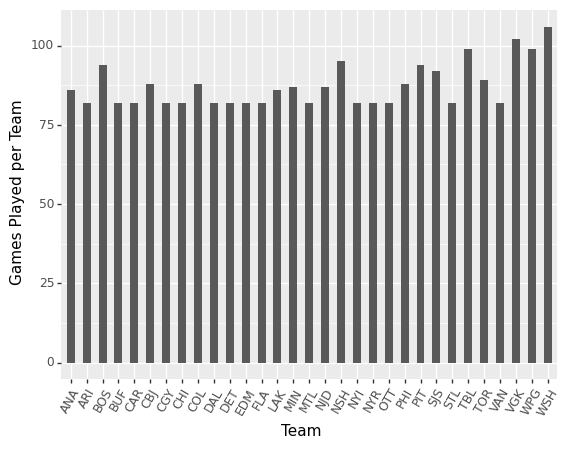

<ggplot: (93956980164)>

In [125]:
(ggplot(teams_games_data_final_2, aes(x='Team')) + geom_histogram(binwidth = 0.5)) + theme(axis_text_x=element_text(angle=60)) + labs(y = "Games Played per Team")

Our first plot was to check the number of games played by each team. This is important because in order to study the numbers ahead, we need to be sure that the teams played equal (or almost equal) number of matches (got equal opportunities) to generate some of the statistics used below. Here wer can see that the minimum number of games played were 80 and the maximum were 107. Most of the teams played around 81 games so our distribution seems to balanced in terms of that.  

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



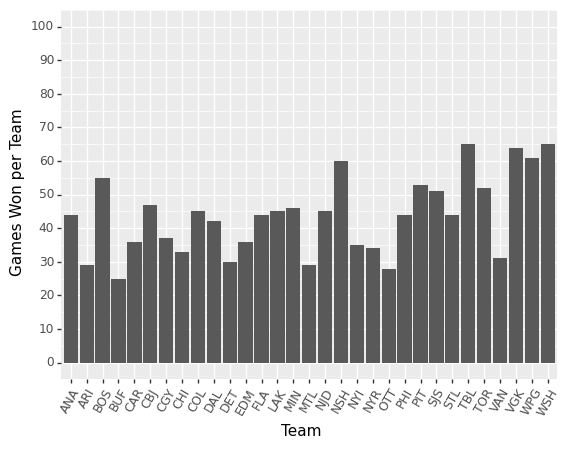

<ggplot: (93954213834)>

In [15]:
wins_per_team_df = teams_data_final.copy().sort_values(['outcome_win?']).reset_index()
wins_per_team = ggplot(wins_per_team_df, aes(x = 'Team', y = 'outcome_win?'))
wins_per_team + geom_bar(stat = 'identity') + theme(axis_text_x=element_text(angle=60)) + labs(y = "Games Won per Team") + scale_y_continuous(breaks=np.arange(0, 101, 10), limits=[0, 100])


This plot shows the number of games won by each team. Again, nothing too imbalanced here.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



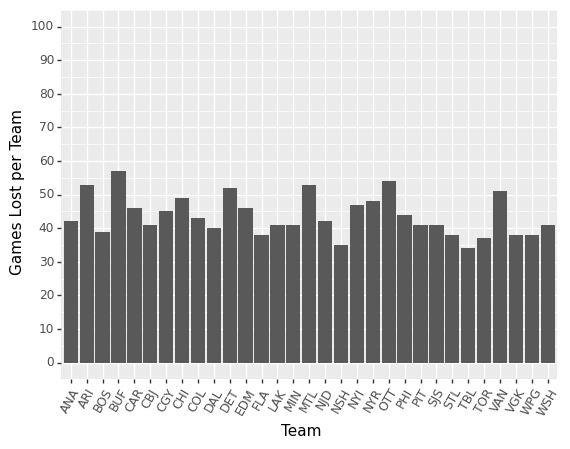

<ggplot: (93955572821)>

In [16]:
gameslost_per_team_df = teams_data_final.copy().sort_values(['outcome_lost?']).reset_index()
gameslost_per_team = ggplot(gameslost_per_team_df, aes(x = 'Team', y = 'outcome_lost?'))
gameslost_per_team + geom_bar(stat = 'identity') + theme(axis_text_x=element_text(angle=60)) + labs(y = "Games Lost per Team") + scale_y_continuous(breaks=np.arange(0, 101, 10), limits=[0, 100])


This plot shows the number of games lost by each team. 

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



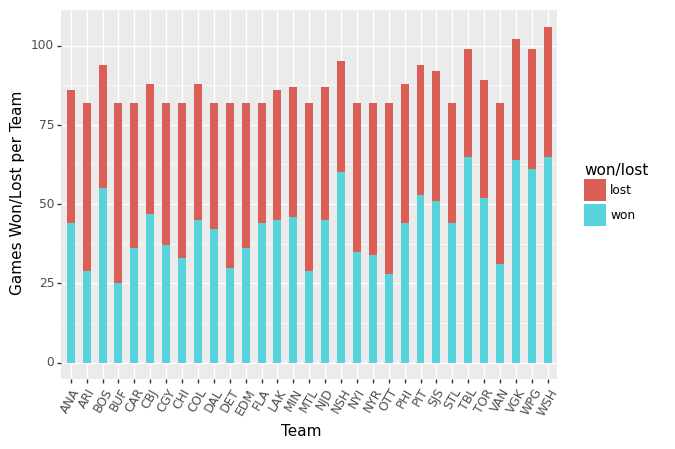

<ggplot: (93955572977)>

In [17]:
(ggplot(teams_games_data_final_2, aes(x='Team', fill='won/lost')) + geom_histogram(binwidth = 0.5)) + theme(axis_text_x=element_text(angle=60)) + labs(y = "Games Won/Lost per Team")


This plot shows the wins and losses of teams stacked on top of each other. The plot gives us a better picture of the performance of different teams. The teams are ordered alphabetically and coincidentally the ones that are on the right side seem to have more wins than losses as compared to most other teams.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



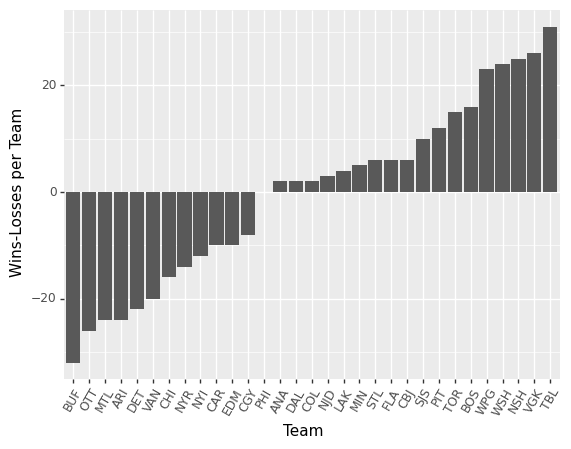

<ggplot: (93955360537)>

In [18]:
win_minus_loss_df = teams_data_final.copy().sort_values(['wl']).reset_index()
#win_minus_loss_df.rename(columns = {'win-loss' : 'wl'}, inplace = True)
win_minus_loss = ggplot(win_minus_loss_df, aes(x = 'reorder(Team, wl)', y = 'wl'))
win_minus_loss + geom_bar(stat = 'identity') + theme(axis_text_x=element_text(angle=60)) + labs(y = "Wins-Losses per Team", x = 'Team')  


This plot will be our main plot for team-wise analysis. The plot has wins minus losses on the y axis and the wins minus losses score for each team in our dataset. The plot has been reordered to show an ascending order in terms of wins minus losses. We will be employing this as the foundation in our next 3 plots.

<ipython-input-126-ef04cc46c9ba>:14: MatplotlibDeprecationWarning:

Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.



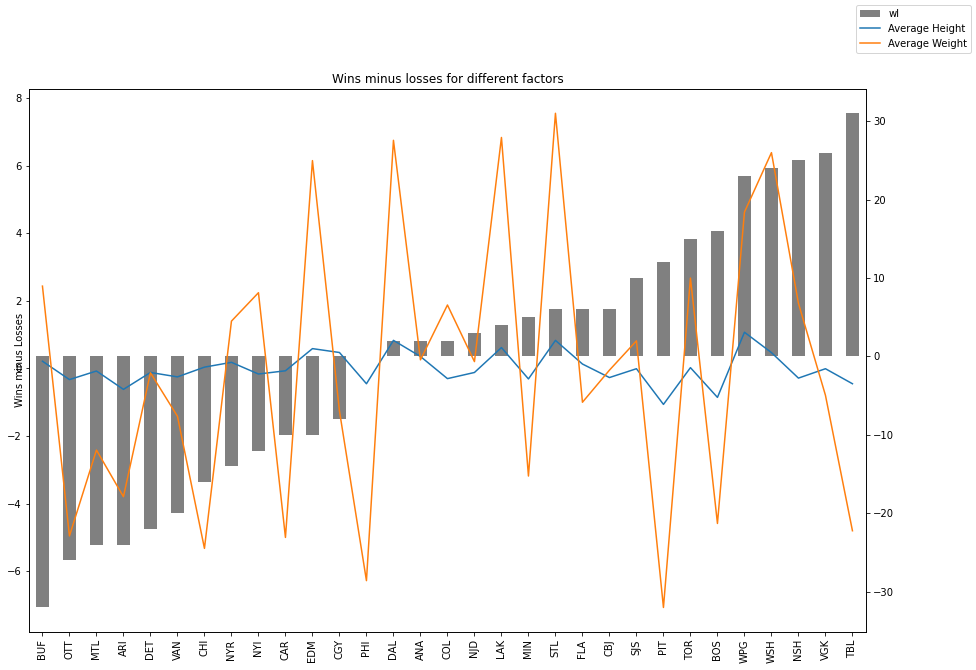

In [126]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
win_minus_loss_df['wl'].plot(kind='bar', color='gray', ax=ax1)
win_minus_loss_df['avg_ht'].plot(kind='line', ax=ax2, label = 'Average Height')
win_minus_loss_df['avg_wt'].plot(kind='line', ax=ax2, label = 'Average Weight')
#win_minus_loss_df['avg_age'].plot(kind='line', ax=ax2, label = 'Average Age')
#win_minus_loss_df['avg_seasons'].plot(kind='line', ax=ax2, label = 'Average Seasons')
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
ax1.axes.set_xticklabels(win_minus_loss_df['Team'])
ax1.set_title('Wins minus losses for different factors')
ax1.set_ylabel('Wins minus Losses')
#ax2.set_ylabel('Average Height of Team minus Total Avg Height')
fig.legend(loc = 'best')

This plot shows the wins minus losses bars plotted against the Average Height per team subtracted by the Average Height for all players and the Average Weight per team subtracted by the Average Weight for all players. This has been done to scale down the variables and bring them all at the same level so that the analysis can be done easily.

Our plot here shows us that the Average Height and Average Weight do not really contribute anything towards a team's performance. The distributions do not show any visible trends that could indicate a strong correlation of the two factors with the wins minus losses. 

<ipython-input-22-498b44f29e47>:14: MatplotlibDeprecationWarning:

Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.



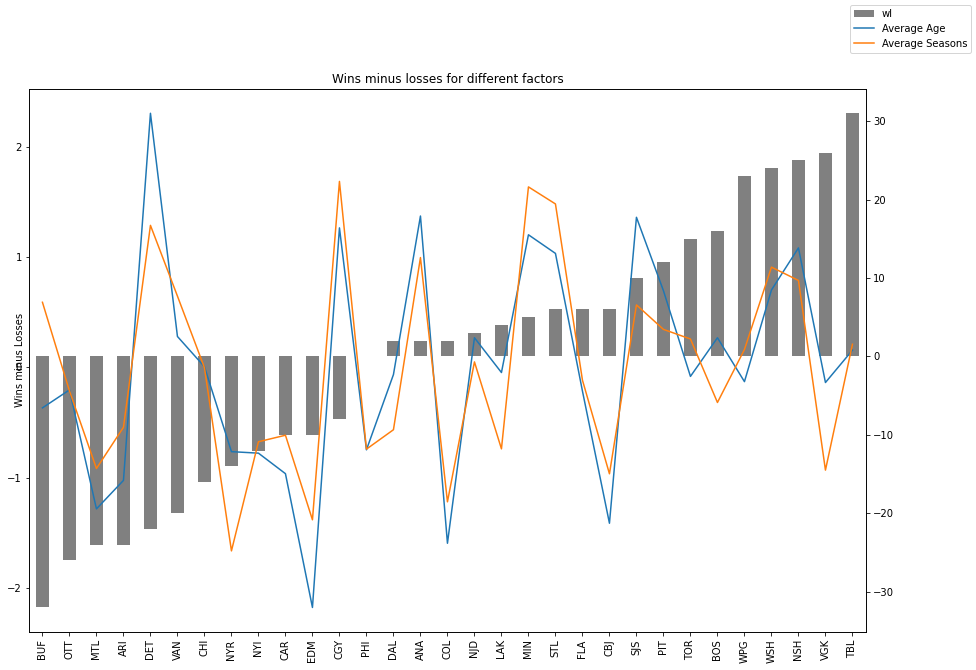

In [22]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
win_minus_loss_df['wl'].plot(kind='bar', color='gray', ax=ax1)
#win_minus_loss_df['avg_ht'].plot(kind='line', ax=ax2, label = 'Average Height')
#win_minus_loss_df['avg_wt'].plot(kind='line', ax=ax2, label = 'Average Weight')
win_minus_loss_df['avg_age'].plot(kind='line', ax=ax2, label = 'Average Age')
win_minus_loss_df['avg_seasons'].plot(kind='line', ax=ax2, label = 'Average Seasons')
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
ax1.axes.set_xticklabels(win_minus_loss_df['Team'])
ax1.set_title('Wins minus losses for different factors')
ax1.set_ylabel('Wins minus Losses')
#ax2.set_ylabel('Average Height of Team minus Total Avg Height')
fig.legend(loc = 'best')

This plot shows the wins minus losses bars plotted against the Average Age per team subtracted by the Average Age for all players and the Average Experience (seasons) per team subtracted by the Average Experience for all players. Again, scaling has been done to bring them all at the same level to increase the efficiency of our analysis.

Firstly, the plot here shows a high correlation between Age and Experience which intuitively makes sense; higher the age, the more experienced the player would be. Secondly, similar to our previous plot, this plot also here shows us that the Average Age and Average Experience contribute little to nothing towards a team's performance. The distributions are haywire, indicating no significant correlation of the two factors with the wins minus losses. 

<ipython-input-127-f4f2f0136a97>:14: MatplotlibDeprecationWarning:

Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.



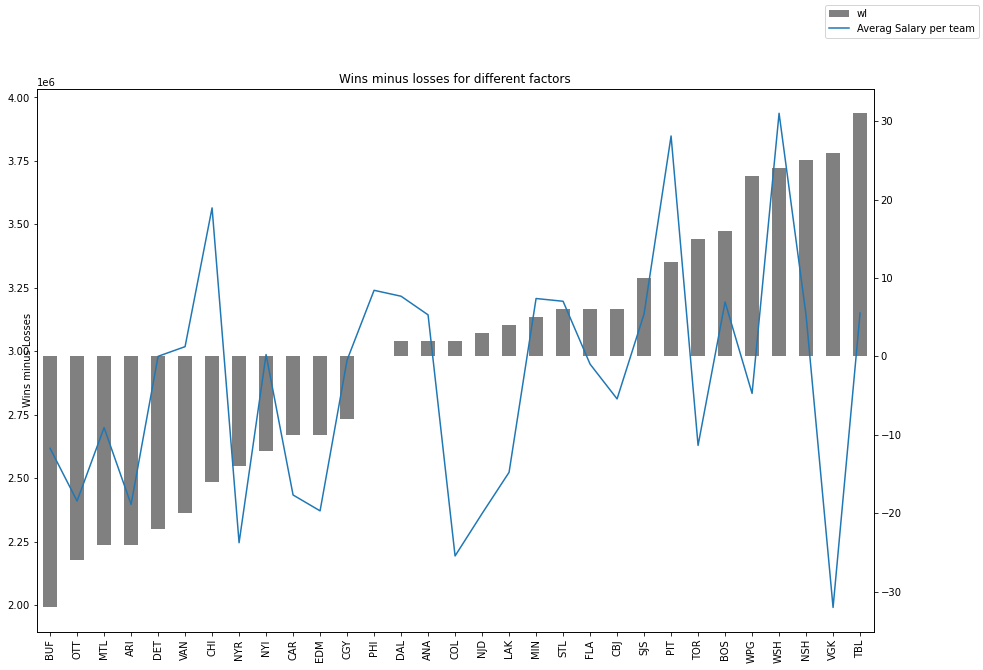

In [127]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
win_minus_loss_df['wl'].plot(kind='bar', color='gray', ax=ax1)
win_minus_loss_df['Salary'].plot(kind='line', ax=ax2, label = 'Averag Salary per team')
#win_minus_loss_df['Salary'].plot(kind='line', ax=ax2, label = 'Average Weight')
#win_minus_loss_df['avg_age'].plot(kind='line', ax=ax2, label = 'Average Age')
#win_minus_loss_df['avg_seasons'].plot(kind='line', ax=ax2, label = 'Average Seasons')
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
ax1.axes.set_xticklabels(win_minus_loss_df['Team'])
ax1.set_title('Wins minus losses for different factors')
ax1.set_ylabel('Wins minus Losses')
#ax2.set_ylabel('Average Height of Team minus Total Avg Height')
fig.legend(loc = 'best')

This plot has the same x-axis as the previous couple of plots and it has the Average Salary per team subtracted by the Average Salary for all teams on the y-axis. Scaling again helps us look at trends in the data.

This graph shows us some interesting results. Apart from a couple of outliers (which we'll talk about in the next plot), there seems to be a positive trend in Average Salary and wins minus losses. This goes in line with our intuition which is: "If you invest money on better players who perform better than other players, they might cost the team more but they would also yield better results in return." This is exactly what we are seeing then. This clearly supports spending higher money on better quality players to get better results. 

There is however still some doubt here because correlation does not imply causation. We cannot conclude that higher investment 'causes' better results, we can however conclude that here seems to be a relatively high correlation between the two.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning:

Confidence intervals are not yet implementedfor lowess smoothings.



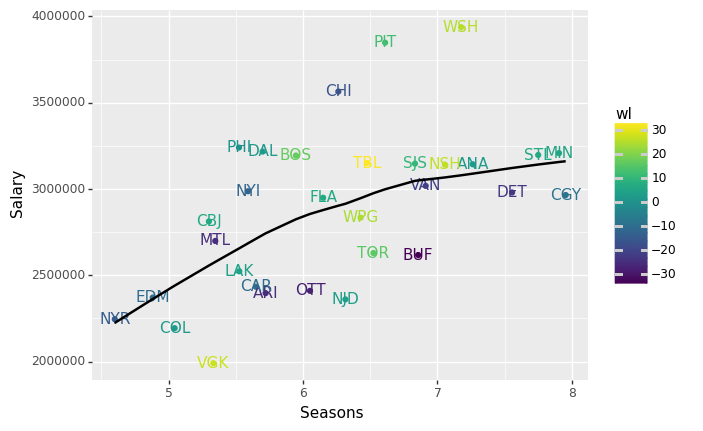

<ggplot: (93955102196)>

In [128]:
ggplot(win_minus_loss_df, aes(x='Seasons', y = 'Salary' , color='wl', label = 'Team')) + geom_point() + geom_text(aes(label='Team')) + geom_smooth()

This plot further explores the idea of success, average salary and the wins minus losses. On the y-axis we have the Average Salary per team, on the x-axis we have the average number of seasons played by the players in each team, the color of the scatter points shows the wins minus losses score (the ligher the color the higher the wins minus losses score and vice versa) and each plot represents a team. We plotted a best-fit line through this to show us where the teams stand against each other.

Firstly, we see a positive trend the Average Salary and Seasons meaning that the higher the number of seasons played by players in a team, the more the team will be paying them for it. The teams above the line show teams with high wins minus losses scores and vice versa. 

There are two outliers here: CHI (Chicago Blackhawks) and VGK (Vegas Golden Knights). CHI having a higher average salary and higher experience would be expected to have a higher wins minus losses but it's not the case as seen in this plot. Whereas VGS has a much smaller average salary and much less average seasons but it had an extremely successful season. This is where the point about 'Spirit' and management comes in which was talked about in the introduction. We observe here that VGK had a successful season possibly because it was their first season in the game and because they were the high-spirited underdogs who wanted to achieve something. On the other hand, CHI probably had a long number of seasons before it and lacked the 'Spirit' and the management needed to achieve the results they would have expected to achieve. 

<ipython-input-129-383065d6ac43>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



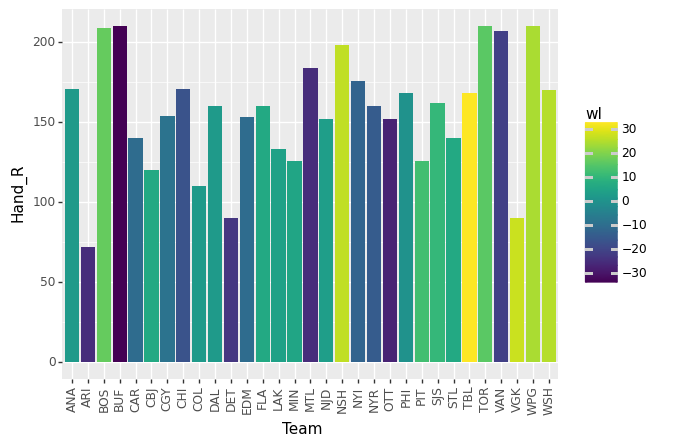

<ggplot: (93953867141)>

In [129]:
single_team_players_teams = pd.merge(single_team_players, teams_data_final, on = 'Team', how = 'left')
single_team_players_teams['Stick'].fillna('NAA', inplace = True)
single_team_players['Stick_Brand'] = single_team_players['Stick'].apply(lambda x: x[:x.find(' ')])

ggplot(single_team_players_teams, aes(x = 'Team', y = 'Hand_R', fill = 'wl')) + geom_bar(stat = 'identity') + theme(axis_text_x=element_text(angle=90))


The plot here has teams on the x-axis, number of players per team who were right handed as the y-axis and the fill of the bars represents the win minus losses score (again the lighter the color the better the wins minus losses score and vice versa).

Here we see no major trend of having a specific type of player on the team performance. Thus we can rule out the possibility of this affect the team performance. 

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



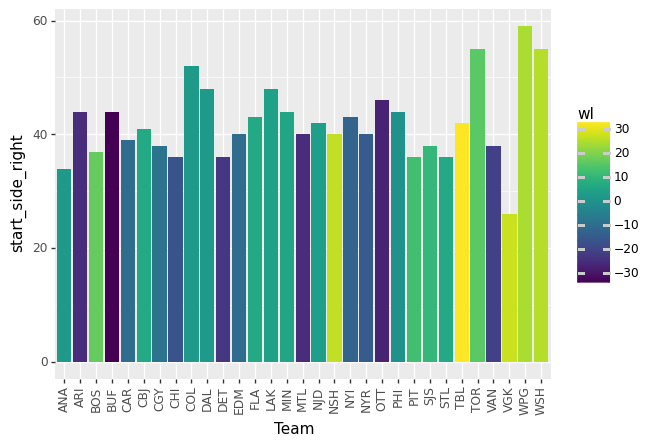

<ggplot: (93956723978)>

In [130]:
ggplot(win_minus_loss_df, aes(x = 'Team', y = 'start_side_right', fill = 'wl')) + geom_bar(stat = 'identity') + theme(axis_text_x=element_text(angle=90))


The plot here has teams on the x-axis, the number of games played in which the team started the game on the right side of the rink and the fill of the bars represents the win minus losses score.

This plot shows a very small but interesting trend. Again correlation does not causlity, so we do not know whether starting on the right side can cause a higher wins minus losses score but we do know that the better performing teams have exercised this in the past. This figure is quite insightful and there's definitely some value that can be derived from this by the teams. 


### Conclusions for Team-level Analysis 

1. Height, Weight and the player being Right-Handed or Left-Handed do not have an impact on a team's performance. Teams do not account for these factors while making decisions about their investments.
2. Age and Experience are highly-correlated with each other and Experience seems to have a positive influence on Salary to a certain point after which the increase in quite small. In terms of value proposition, teams should avoid investing in too many players who are in their 7th season or higher because the return on investment isn't that high anymore.
3. Salary has a positive influence on win minus loss score (except for two outliers) so higher investment generally leads to higher returns.
4. Relatively more successful teams have generally started their games from the right side of the rink, something that the other teams could learn from.

## Where do the best players in the world come from?

One of the most heated conversations in the hockey community is over which country produces the highest quality players. Given the United States and Canada's geographical and economic advantages (relatively high GPD/capita, lots of highly populated northern cities that experience prolonged, cold winters), a logical hypothesis is that they have the most resources (both economic and natural) to devote to the development of young players and produce the most product players. What we found is that while these North American countries make up the vast majority of the players currently in the NHL, they do not significantly out perform of players to the NHL. The average Canadian player, for example, from top contributing nation in terms of number of players in the game, leads only in one category - the number of career penalty minutes served. As NHL hockey teams, based in Canada and the United States, expand their international partnerships to tap into foreign talent markets, our findings can be used to guide their target nations. 

In [78]:
#http://www.hockeyabstract.com/testimonials/nhl2017-18
s1718 = pd.read_excel("NHL 2017-18.xls", header = 2)

In [79]:
gp_alpha = [0.5 if i < 40 else 1 for i in s1718['GP']]

In [80]:
s1718['gp_alpha'] = gp_alpha

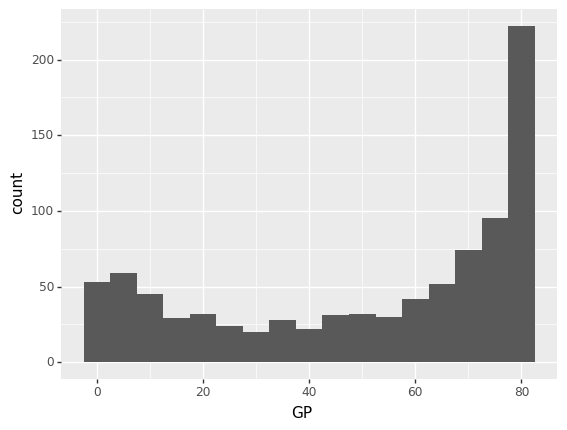

<ggplot: (93956573359)>

In [81]:
ggplot(s1718, aes(x = 'GP')) + geom_histogram(binwidth = 5)

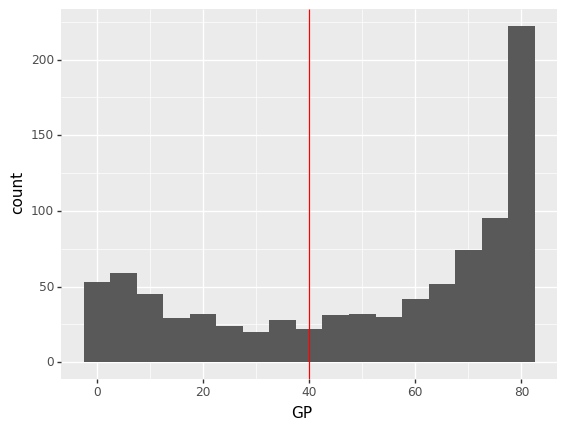

<ggplot: (93959015434)>

In [82]:
ggplot(s1718, aes(x = 'GP')) + geom_histogram(binwidth = 5) + geom_vline(xintercept=40, color = 'red')

Take only players on the right portion of this graph

Group season data by country of origin - eliminate players who played less than 60 games over the course of the season. Because the bottom portion of NHL rosters remain fluid over the course of the season, young players will often only see ice time in a handful of games spread throughout the course of a season. Without consistent play, accurate catch-all metrics that we will analyze don't provide reliable estimates of player contribution. It takes time to establish chemistry with other players in the lineup and develop confidence in ones play, so we excluded players who didn't play at least half of games in the the season (about 41 games). While this does limit our sample size, there are still sufficient players from the major contributing countries to make meaningful conclusions.

In [83]:
s1718_exp = s1718[s1718['GP'] > 40]

In [84]:
cntrs = s1718_exp.groupby(by=['Cntry'])

Create dataframe storing the countries (by abbreviation) and the number of active players they had in the 2017-2018 season

In [85]:
nation_counts = cntrs.size()
nation_counts = nation_counts.reset_index()
nation_counts.columns = ['Cntry','n']

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



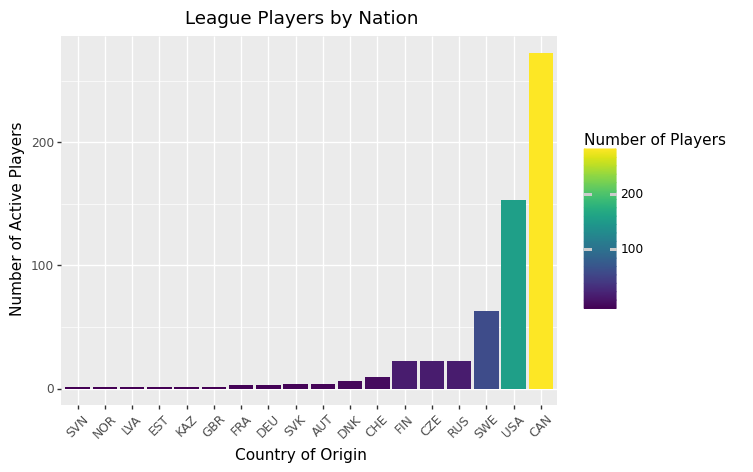

<ggplot: (93952737241)>

In [86]:
ggplot(nation_counts, aes(x = 'reorder(Cntry,n)', y = 'n', fill = 'n')) + theme(axis_text_x=element_text(angle=45)) + geom_col() + xlab('Country of Origin') + ylab('Number of Active Players') + labs(title='League Players by Nation', fill = "Number of Players")

As expected, the North American countries dominate the NHL in terms of player representation. Canada especially dominating the field. with the US at about half the player pool size, and the rest of the world trailing significantly.

***

## How do countries compare in terms of player contributions?

Now we have established how the nationality profile of the NHL - it is dominated by North American players from Canada and the United States, but Eastern European countries contribute a fair number of players relative the the rest of the world as well. We wanted to see if this dominance by the North American countries has more to do with geographical convenience, or if the performance of these country's players warrants their disproportionate share of spots on NHL teams. Looking at handful of commonly used "catch-all" statistics, which aggregate a number of offensive and defensive measures used to evaluate player performance (things like goals, blocked shots, time on ice (TOI)) into single score, we have found that the North American countries do not out-perform their Easter European or Scandanavian counterparts anywhere near their advantage in player pool size.

1. Extract possible columns to expore

In [87]:
COI = ['NHLid','Cntry','City','Born','Car_GP','Car_G','Car_A','Car_PTS','Car_PM','Car_PIM','Car_Shot','Car_TOI','Car_OPS','Car_DPS','Car_PS','Salary','WAR','OWAR','DWAR','Seasons', 'CriG']

In order to avoid analyzing countries with especially small player sample sizes, we chose a cutoff of 10 active players in the 2017-2018 dataset. This means that most of the countries in the dataset will be removed, but those countries represent a very small fraction of the NHL player pool.

In [88]:
to_keep = [i for i in cntrs.size().index if cntrs.size()[i] > 10]
major_cnts = s1718[s1718['Cntry'].isin(to_keep)]

Isolate columns of interest

In [90]:
major_cnts_data = major_cnts[COI]

We looked at both median and average values for the various columns of interest to account for extreme outliers, but the comparisons hold regardless of statiscal measure.

In [91]:
cntr_agg = major_cnts_data.groupby(by=['Cntry']).aggregate(np.sum)

In [92]:
cntr_agg = cntr_agg.merge(nation_counts, on = ['Cntry'])

In [93]:
cntr_agg['avg_WAR'] = cntr_agg['WAR']/cntr_agg['n']
cntr_agg['avg_OWAR'] = cntr_agg['OWAR']/cntr_agg['n']
cntr_agg['avg_DWAR'] = cntr_agg['DWAR']/cntr_agg['n']
cntr_agg['avg_sal'] = cntr_agg['Salary']/cntr_agg['n']
cntr_agg['avg_G'] = cntr_agg['Car_G']/cntr_agg['n']
cntr_agg['avg_A'] = cntr_agg['Car_A']/cntr_agg['n']
cntr_agg['avg_PTS'] = cntr_agg['Car_PTS']/cntr_agg['n']
cntr_agg['avg_PIM'] = cntr_agg['Car_PIM']/cntr_agg['n']
cntr_agg['avg_DPS'] = cntr_agg['Car_DPS']/cntr_agg['n']
cntr_agg['avg_OPS'] = cntr_agg['Car_OPS']/cntr_agg['n']
cntr_agg['avg_TOI'] = (cntr_agg['Car_TOI']/cntr_agg['Seasons'])
cntr_agg['avg_season'] = cntr_agg['Seasons']/cntr_agg['n']
cntr_agg['avg_critG'] = cntr_agg['CriG']/cntr_agg['n']

Another factor on top of games played that impacts a players ability to fully "express themselves analytically" is the amount of ice time they are given in the games that they dress for. We checked to see that the average career TOI was relatiely consistent across nations over the average season (by dividing total TOI by the total number of seasons played by players of each nationality). We also wanted to see if countries with more player seasons see more TOI.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



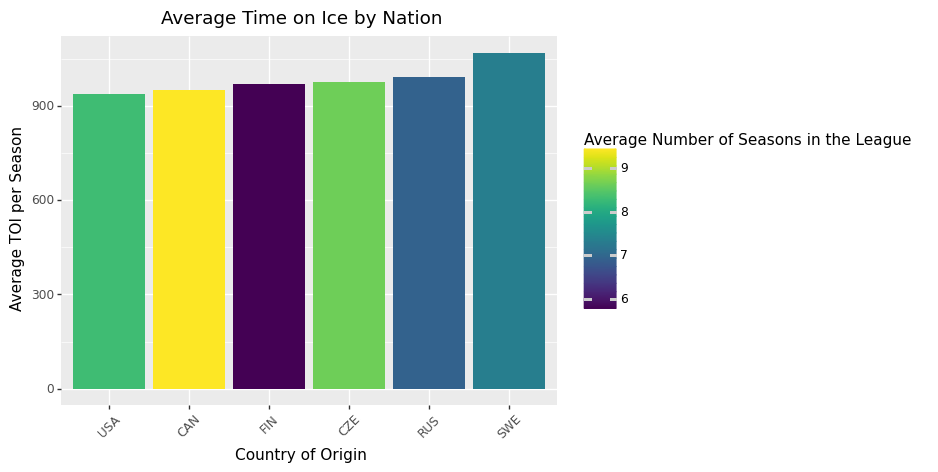

<ggplot: (93954215030)>

In [94]:
ggplot(cntr_agg, aes(x = 'reorder(Cntry,avg_TOI)', y = 'avg_TOI', fill = 'avg_season')) \
+ theme(axis_text_x=element_text(angle=45)) + geom_col() + xlab('Country of Origin')\
+ ylab('Average TOI per Season') + labs(title='Average Time on Ice by Nation', fill = "Average Number of Seasons in the League")

Fortunately for our analysis, there does not seem to be any significant differences in average playing time for a season by nationality. This strengthens our confidence that the following findings will hold water.

### Wins Above Replacement - Overall, Offensive, and Defensive Measures

The first metric to evaluate is the average Wins-Above-Replacement (WAR) metric, which is a catch-all measure of a players contributions to their team. It describes how many additional wins a player gives their team relative to a replacement level (about average) player would. This has become a very common metric used to compare players as it accounts for a number of different factors that pure offensive or defensive productions don't capture. Wins are the most important outcome for a team, and how players factor into the expected number of wins is therefore a very important measure. 

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



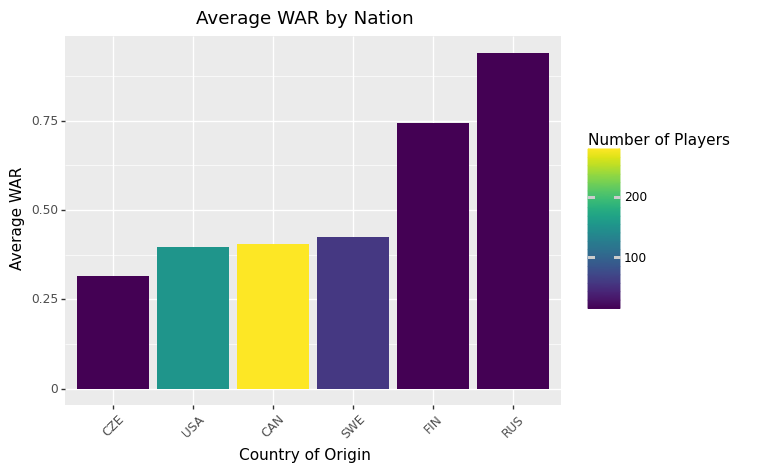

<ggplot: (93959066757)>

In [95]:
ggplot(cntr_agg, aes(x = 'reorder(Cntry,avg_WAR)', y = 'avg_WAR', fill = 'n')) \
+ theme(axis_text_x=element_text(angle=45)) + geom_col() + xlab('Country of Origin')\
+ ylab('Average WAR') + labs(title='Average WAR by Nation', fill = "Number of Players")

The top two countries in terms of player engagement in the NHL do surprisingly poorly when evaluated based on their aggregate contributions to wins. With the exception of the Czech Republic, its seems like there is a negative correlation with the number of player in the league and the average wins above replacement of players for a given country. Its possible that this is a reflection of the fewer hurdles North American players have to face to gain entry to the league. They grow up in close proximity to the teams, who scout heavily in North American cities due to the low cost of doing so. Players from countries on the other side of the world with less hockey infrastructure must exceed their North American counterparts to get noticed and drafted into the league. 

***

### Does this trend hold up when looking specifically at offensive contributions?

##### Offensive Wins Above Replacement

Offensive WAR (OWAR) is a daughter metric of the overall WAR that focuses purely on how a player's offensive contributions translate into additional wins for a team.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



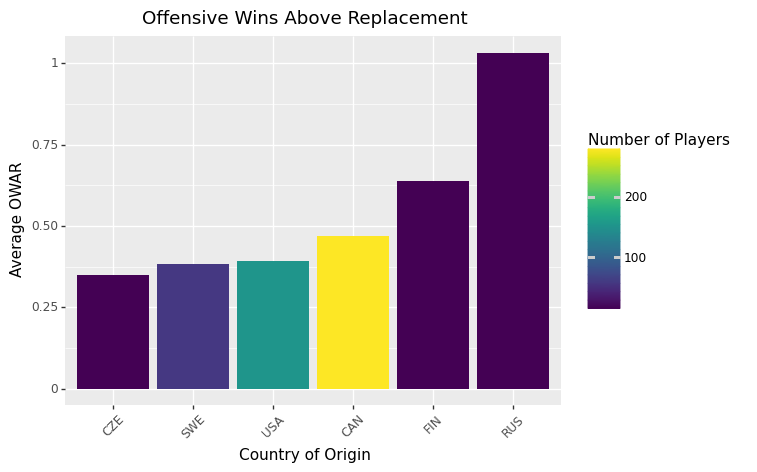

<ggplot: (93956796742)>

In [98]:
ggplot(cntr_agg,aes(x = 'reorder(Cntry,avg_OWAR)', y = 'avg_OWAR', fill = 'n')) \
+ geom_col(position = 'dodge') + theme(axis_text_x=element_text(angle=45)) + \
xlab('Country of Origin') + ylab('Average OWAR') + labs(title='Offensive Wins Above Replacement', fill = "Number of Players")

Very similar to the overall catch-all WAR, the North American Countries fall in the middle of the pack with Finland and Russia leading the way. 

##### Offensive Point Share

To see if OWAR and Offensive Point Share (OPS, another catch-all metric that aggregates a number of offensive production statistics, such as goals scored, how many points was the player on the ice for even in not involved in the play etc while taking into account how much ice time that player gets) show similar trends across our nations of interest, we plotted the average OPS for each nation.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



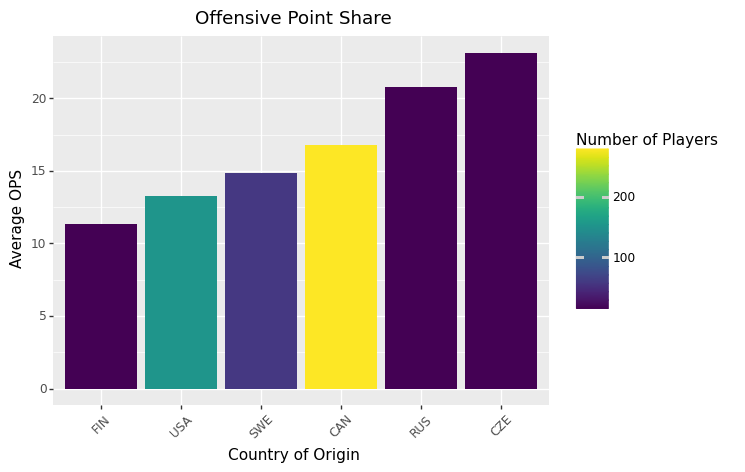

<ggplot: (93954209317)>

In [99]:
ggplot(cntr_agg,aes(x = 'reorder(Cntry,avg_OPS)', y = 'avg_OPS', fill = 'n')) \
+ geom_col(position = 'dodge') + theme(axis_text_x=element_text(angle=45)) + \
xlab('Country of Origin') + ylab('Average OPS') + labs(title='Offensive Point Share', fill = "Number of Players")

While the trend mostly holds true, Finland saw a big drop in their ranking with the Czech Republic jumped into the top spot. This could indicate that while Fins contribute less in terms of offensive points, the offensive points they do contribute are more likely to help teams win games - which OWAR does take into account - and the opposite being true for players from the Czech Republic. 

To evaluate this hypothesis, we look at the average number of critical goals scored (defined as goals that either tie the game or give the player's team a lead in the 3rd period of the game) across nations. This analysis tries to see if different nations produce "big time playmakers" who score the most meaningful goals.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



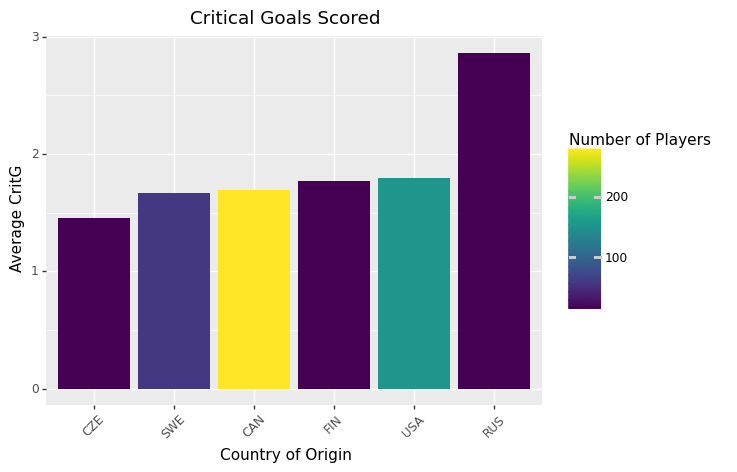

<ggplot: (93955508905)>

In [100]:
ggplot(cntr_agg,aes(x = 'reorder(Cntry,avg_critG)', y = 'avg_critG', fill = 'n')) \
+ geom_col(position = 'dodge') + theme(axis_text_x=element_text(angle=45)) + \
xlab('Country of Origin') + ylab('Average CritG') + labs(title='Critical Goals Scored', fill = "Number of Players")

This plot confirms our hypothesis that Fins score more critical goals and Czech players fewer. The difference between the two seems marginal, but it should be noted that a single goal that contributes to a win will show a large effect in OWAR, but does not get weighted heavier than any other goal in OPS. So even a small difference in critical goals scored could explain the discrepencies between OWAR and OPS.

This finding prompted us to take a step back and look at individual players, to see if there is a relationship between critical points (now including goals and assists) and OWAR.

### Do OWAR and OPS capture overlapping information? 

Aggregate critical measures (CriA1/2 is for primary and secondary assists)

In [101]:
s1718['CritPts'] = s1718['CriG'] + s1718['CriA1'] + s1718['CriA2']

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



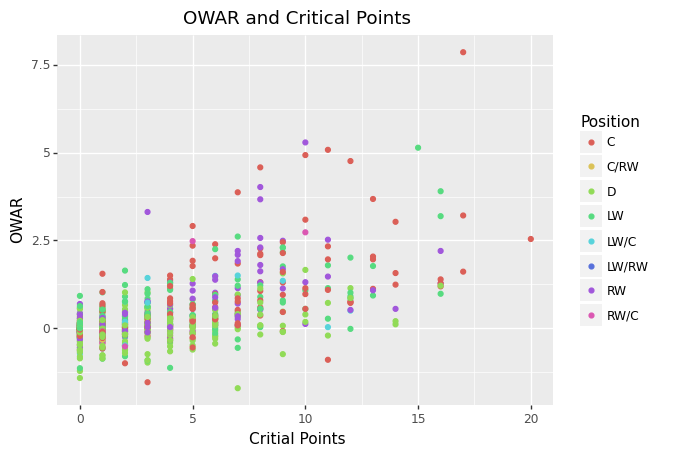

<ggplot: (93955485124)>

In [102]:
ggplot(s1718)\
+ geom_point(aes('CritPts', 'OWAR', color = 'Position')) +\
xlab("Critial Points") + ylab("OWAR") + labs(title = 'OWAR and Critical Points')

Our analysis confirms our hypothesis that OWAR and critical points scored have a relative strong positive correlation - reinforcing our confidence in our analysis of OWAR vs OPS. Now we want to perform a similar analysis, but looking at defensive WAR (DWAR) and point share (DPS). Quantifying defense is a notoriously and inherently difficult task because often good defense means nothing happens on the ice, so we predict a much less clear trend.

***

### Now to look at defensive contributions...

##### Defensive WAR (DWAR)

Another daughter metric of the general WAR, this metric aims to evaluate how a player's defensive contributions contribute to extra wins (relative to a replacement level player)

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



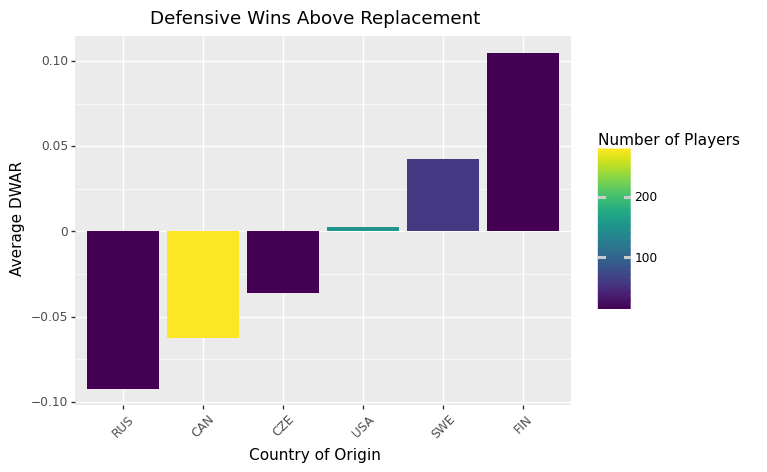

<ggplot: (93953827063)>

In [103]:
ggplot(cntr_agg,aes(x = 'reorder(Cntry,avg_DWAR)', y = 'avg_DWAR', fill = 'n')) \
+ geom_col(position = 'dodge') + theme(axis_text_x=element_text(angle=45)) + \
xlab('Country of Origin') + ylab('Average DWAR') + labs(title='Defensive Wins Above Replacement', fill = "Number of Players")

This was an especially surprising result - with three of the nations actually having a negative DWAR. Clearly when viewed in the context of OWAR, Russian players are very offensively inclined, ranking first in OWAR but last in OWAR, with Finnish players ranking highly in both categories.

Does this trend translate to defensive point share (DPS)? 

##### Defensive Point Share (DPS)

DPS is the analogous metric to OPS, with the caveat the defensive "points" are not something measured in hockey. This metric looks at goals against while the player is on the ice, possession time with this player on ice, blocked shots, and a number of other defensive measures. 

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



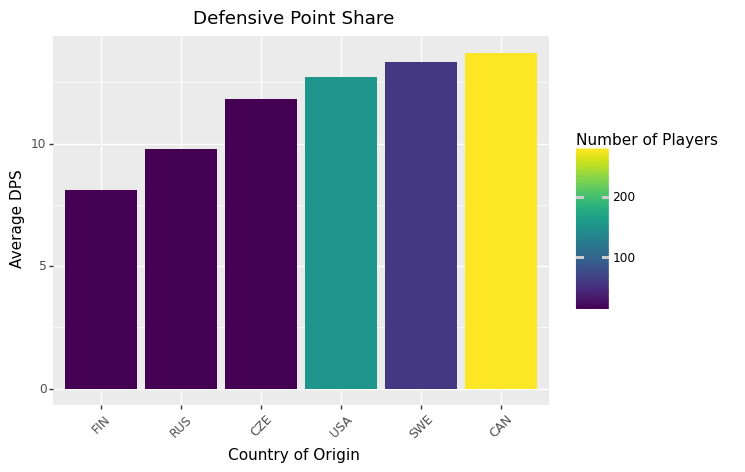

<ggplot: (93957184928)>

In [104]:
ggplot(cntr_agg,aes(x = 'reorder(Cntry,avg_DPS)', y = 'avg_DPS', fill = 'n')) \
+ geom_col(position = 'dodge') + theme(axis_text_x=element_text(angle=45)) + \
xlab('Country of Origin') + ylab('Average DPS') + labs(title='Defensive Point Share', fill = "Number of Players")

As with the OWAR vs OPS analysis, DPS and DWAR appear to be capturing overlapping but distinct information. Unfortunately, there are no current metrics for critical defensive plays as there are for offensive plays, so it is not possible to determine whether players from Finland, for example, contribute less defensive "points" but more meaningful defensive in terms of their teams winning. Instead, we decided to see if there was any relationship between the two metrics looking at individual players.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



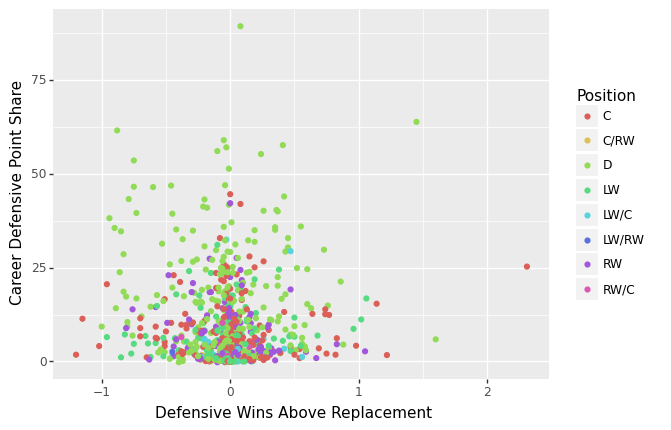

<ggplot: (93953245986)>

In [106]:
ggplot(s1718) + geom_point(aes('DWAR', 'Car_DPS', color = 'Position')) + xlab("Defensive Wins Above Replacement") + ylab("Career Defensive Point Share")

There appeears to be no relationship between DPS and DWAR, which brings into question the validity of the two metrics. How can two defensive catch-all statistics be so uncorrelated? We decided then to look at how teams are using these statistics in terms of valuing defensive players. We limit this analysis to defensemen because salary choices for forwards may not be based on defensive ability, or only to a limited degree.

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\layer.py:464: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.



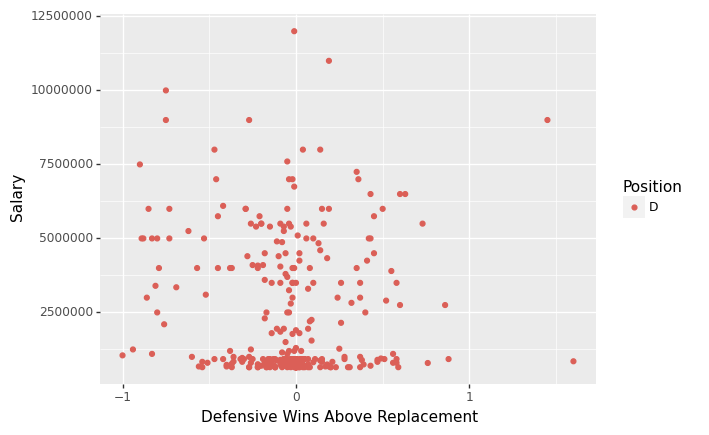

<ggplot: (93952838033)>

In [107]:
ggplot(s1718[s1718['Position'] == 'D']) + geom_point(aes('DWAR', 'Salary', color = 'Position')) + xlab("Defensive Wins Above Replacement") + ylab("Salary")

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

C:\Users\ali_1\anaconda3\lib\site-packages\plotnine\layer.py:464: PlotnineWarning:

geom_point : Removed 3 rows containing missing values.



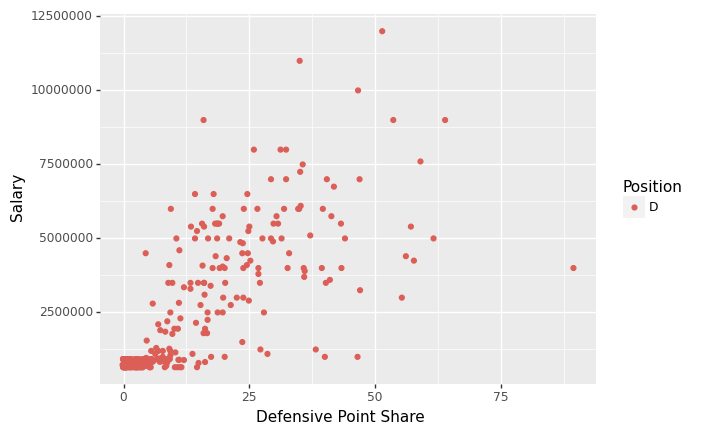

<ggplot: (93955494413)>

In [108]:
ggplot(s1718[s1718['Position'] == 'D']) + geom_point(aes('Car_DPS', 'Salary', color = 'Position')) + xlab("Defensive Point Share") + ylab("Salary")

Salary and DWAR appears to have no relationship whatsover, with some of the highest paid defensemen actually having negative DWAR. DPS and salary have a clear positive correlation, on the other hand. This finding does not necessarily indicate that teams place higher value on players with higher DPS scores, but it does say that those players tend to get paid more and likely have better overall defensive ability. This finding brings into question the utility of DWAR as a defensive metric at all.

### Conclusions:

This international analysis brings up a few useful findings:
1. North American players do not outperform their peers across the sea in Eastern Europe and Scandanavia across a variety of metrics. Though Canadian players rank first in DPS, it is by a very slim margin and they rank second to last in DWAR. 
2. Hockey clubs looking to invest resources into developing international players should look to Finland and Russia for top talent. Finnish players ranked highly in almost every metric, while Russian players ranked highly in offensive measures. So clubs looking to find good offensive talent should look to Russia.
3. DWAR as a statistic may not be capturing useful information and teams/analysts should avoid using this to make any conclusions about a players defensive capability.

## Which states to focus recruitment efforts on?

As a "cherry on top" analysis, we wanted to look at where American born players are coming from, as this would be helpful information for teams looking to refine their scouting efforts and focus on states that tend to produce more talent.

Group player data into states

In [109]:
state_counts = major_cnts[major_cnts['Cntry'] == 'USA']

In [110]:
state_counts = state_counts.groupby(by='Pr/St')

In [111]:
state_counts = state_counts.size()

In [112]:
state_counts = pd.DataFrame(state_counts)

In [113]:
state_counts = state_counts.reset_index()

In [114]:
state_counts.columns = ['ST','Number of Active Players']

In [115]:
fig = px.choropleth(state_counts, locations = "ST" , locationmode = "USA-states", color ="Number of Active Players",scope="usa", 
                    color_continuous_scale=px.colors.sequential.Viridis,title="Where American Born Professional Hockey Players Call Home")

In [116]:
plot(fig)

'temp-plot.html'

Teams should focus their efforts on Michigan, Minnesota, New York, and Massachussets to find young talent that is more likely to make it to the NHL level.

***